In [1]:
import os
import nltk
import tweepy
from dotenv import load_dotenv
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import datetime
import re
import cv2
import numpy as np
import pandas as pd
import pickle

In [2]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

In [3]:
load_dotenv()
TWITTER_BEARER_TOKEN = os.getenv('TWITTER_BEARER_TOKEN')
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

In [4]:
print("Authenticating to Twitter...")

client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN, wait_on_rate_limit=True)
auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

Authenticating to Twitter...


In [5]:
twitter_russia_sources_rus_usernames = ["@1tvru_news", "@ru_rbc",
                                         "@er_novosti",
                              "@rt_com",
                              "@medvedevrussia", "@kremlinrussia",
                              "@rentvchannel", "@vesti_news", "@kpru"]

twitter_ukraine_sources_rus_usernames = ["@dmitry_gordon", "@SvobodaRadio",
                               "@euronewsru", "@FeyginMark4", "@tvrain", "@teamnavalny"]

twitter_ukraine_sources_ukr_usernames = ["@HromadskeUA", "@tsnua", "@24tvua", "@unian",
                               "@radiosvoboda", "@5channel", "@EspresoTV"]

twitter_ukraine_sources_eng_usernames = ["@mschwirtz", "@KyivIndependent", "@KyivPost",
                               "@mchancecnn", "@fpleitgenCNN", "@Kasparov63",
                               "@ikhurshudyan", "@myroslavapetsa",
                               "@langfittnpr", "@ElBeardsley", "@timkmak"]

https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

In [6]:
def get_user_id_from_username(username):
    user = api.get_user(screen_name=username)
    return user.id

In [7]:
russia_sources_rus = []
ukraine_sources_rus = []
ukraine_sources_ukr = []
ukraine_sources_eng = []

In [8]:
LOAD_CLUSTERS_DATA = True

In [9]:
if not LOAD_CLUSTERS_DATA:
    for username in twitter_russia_sources_rus_usernames:
        russia_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_rus_usernames:
        ukraine_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_ukr_usernames:
        ukraine_sources_ukr.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_eng_usernames:
        ukraine_sources_eng.append((username, get_user_id_from_username(username)))

In [10]:
if not LOAD_CLUSTERS_DATA:
    russia_sources_rus_pickled = pickle.dumps(russia_sources_rus)
    ukraine_sources_rus_pickled = pickle.dumps(ukraine_sources_rus)
    ukraine_sources_ukr_pickled = pickle.dumps(ukraine_sources_ukr)
    ukraine_sources_eng_pickled = pickle.dumps(ukraine_sources_eng)

In [11]:
CLUSTERS_SERIALIZATION_DIR = "data_clusters/"

In [12]:
if not LOAD_CLUSTERS_DATA:
    print("Writing pickled data to a file...")

    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle', 'wb') as f:
        f.write(russia_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_ukr_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled.pickle','wb') as f:
        f.write(ukraine_sources_eng_pickled)

In [13]:
if LOAD_CLUSTERS_DATA:
    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle',\
            'rb') as f:
        russia_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_ukr = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_eng = pickle.load(f)

In [14]:
def get_user_followers(user_name, user_id, num_pages=1):
    followers = []
    # User rate limit (User context): 15 requests per 15-minute window per each authenticated user
    # limit – Maximum number of requests to make to the API
    # max_results : The maximum number of results to be returned per page. This can be a number between 1 and the 1000. By default, each page will return 100 results.
    # I.E. 15 000 followers can be returned in 15 minutes
    followers_paginator = tweepy.Paginator(client.get_users_followers, id =
    user_id, max_results = 1000, limit = num_pages).flatten()
    for follower in followers_paginator:
        followers.append(follower)
    return (user_name, user_id), followers

In [15]:
def get_user_follower_count(user_id):
    # fetching the user
    user = api.get_user(user_id = user_id)
    return user.followers_count

In [16]:
rus_cluster_followers = []
ukr_eng_cluster_followers = []
ukr_rus_cluster_followers = []
ukr_ukr_cluster_followers = []

In [17]:
# PRODUCTION CODE
# get 105 000 followers per cluster: 1:45 min per cluster, 105 requests

'''
for cluster in russia_sources_rus:
    rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_rus:
    ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_ukr:
    ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_eng:
    ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))
'''

'\nfor cluster in russia_sources_rus:\n    rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_rus:\n    ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_ukr:\n    ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_eng:\n    ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n'

In [18]:
# TEST CODE: 1000 followers per cluster, 2 cluster per each
for i in range(0, 2):
    rus_cluster_followers.append(get_user_followers(russia_sources_rus[i][0],                                               russia_sources_rus[i][1]))

for i in range(0, 2):
    ukr_eng_cluster_followers.append(get_user_followers(ukraine_sources_rus[i][0],                                               ukraine_sources_rus[i][1]))

In [19]:
print(ukr_eng_cluster_followers)

[(('@dmitry_gordon', 1334400780), [<User id=1598081030602330112 name=Стэнли Болдуин username=stalinbidlan>, <User id=1598078516305821701 name=Alex Rozhkovskiy username=kikeraa_alex>, <User id=1729024562 name=Кирилл Чигирин username=krocodilich>, <User id=1598073875249725444 name=Саня Ситников username=shishka164>, <User id=1598072342571352091 name=Шиза Жиза username=ZusSus99>, <User id=1556366859791994882 name=Сергій Дудін username=DudinSergij>, <User id=1590109064079544321 name=Jahongir username=Ceyhun6710>, <User id=1598069503124013066 name=Юли username=Ste_ce_nko>, <User id=1598067534225461250 name=Inna Faruseu username=IFaruseu>, <User id=1492486714375520262 name=Николай Сергейко username=NSergejko>, <User id=1598063412759740416 name=Евгений Савенко username=EvgenijOmts>, <User id=1598060438427734024 name=VexyXD2 username=VexyXd2>, <User id=1598057771303403522 name=Алексей Солоп username=OleksiiSolop>, <User id=1598045637903323174 name=Славик Яковлев username=slavik_akovlev>, <User

In [20]:
'''
print(type(followers[('@minregion_ua', 3333475643)][0]))
print(followers[('@minregion_ua', 3333475643)][0].name)
print(followers[('@minregion_ua', 3333475643)][0].id)
'''

"\nprint(type(followers[('@minregion_ua', 3333475643)][0]))\nprint(followers[('@minregion_ua', 3333475643)][0].name)\nprint(followers[('@minregion_ua', 3333475643)][0].id)\n"

In [21]:
CLUSTER_IDX = 0
FOLLOWER_IDX = 1

rus_cluster = {}
ukr_eng_cluster = {}
ukr_rus_cluster = {}
ukr_ukr_cluster = {}

In [22]:
def cluster_to_df(cluster_list):

    cluster_dfs = {}

    for cluster in cluster_list:
        follower_names = [follower.name for follower in cluster[FOLLOWER_IDX]]
        follower_ids = [follower.id for follower in cluster[FOLLOWER_IDX]]
        followers_data = {
            'username': follower_names,
            'user_id': follower_ids
        }
        cluster_dfs[cluster[CLUSTER_IDX]] = pd.DataFrame(followers_data)

    return cluster_dfs

In [23]:
rus_cluster = cluster_to_df(rus_cluster_followers)
ukr_eng_cluster = cluster_to_df(ukr_eng_cluster_followers)
ukr_rus_cluster = cluster_to_df(ukr_rus_cluster_followers)
ukr_ukr_cluster = cluster_to_df(ukr_ukr_cluster_followers)

In [62]:
# this fucntion converts a list of cluster centers and their followers to csv
# files
CLUSTERS_DIR = "clusters/"

def clusters_to_files(clusters_df):
    for cluster_center, cluster_followers in clusters_df.items():
        cluster_csv = cluster_followers.to_csv()
        with open(CLUSTERS_DIR + cluster_center[CLUSTER_IDX][1:] + '_' + str(cluster_center[FOLLOWER_IDX]) + '.csv',
                  'w') as f:
            f.write(cluster_csv)

In [63]:
clusters_to_files(rus_cluster)
clusters_to_files(ukr_eng_cluster)

<h2>Visualizing Connections as a Graph</h2>

In [26]:
ukr_eng_cluster[('@dmitry_gordon',
  1334400780)]

,username,user_id
0,Стэнли Болдуин,1598081030602330112
1,Alex Rozhkovskiy,1598078516305821701
2,Кирилл Чигирин,1729024562
3,Саня Ситников,1598073875249725444
4,Шиза Жиза,1598072342571352091
...,...,...
994,osinatallosa,1595004955957551105
995,Atebehonedinola,1594999532860866564
996,Yaryna Manischyk,1547306520047673345
997,nihedetataferu,1594998234128187392


In [27]:
import networkx as nx

In [64]:
print("Creating a DataFrame containing the complete graph")

GROUP_ID_MAP = {
    "rus_cluster": 0,
    "ukr_eng_cluster": 1,
    "ukr_rus_cluster": 2,
    "ukr_ukr_cluster": 3
}

global_graph_pd = pd.DataFrame(columns=['username', 'user_id',
                                     'cluster_name', 'cluster_id',
                                     'cluster_follow_count', 'group_id'])

Creating a DataFrame containing the complete graph


In [65]:
def add_cluster_to_global_graph(cluster, group_name, graph_pd):
    curr_cluster_df = pd.DataFrame()
    for cluster_center, cluster_followers in cluster.items():
        curr_cluster_df = cluster_followers.copy(deep=True)
        curr_cluster_df.insert(2, "cluster_name", cluster_center[0])
        curr_cluster_df.insert(3, "cluster_id", int(cluster_center[1]))
        curr_cluster_df.insert(4, "cluster_follow_count",
                               get_user_follower_count(cluster_center[1]),
                               True)
        curr_cluster_df.insert(5, "group_id", GROUP_ID_MAP[group_name])
    return pd.concat([graph_pd, curr_cluster_df])

In [66]:
def save_image(img, img_name):
    IMG_DIR = "visualizations/"
    plt.imsave(IMG_DIR + img_name, img)

In [67]:
global_graph_pd = add_cluster_to_global_graph(rus_cluster, "rus_cluster", global_graph_pd)
global_graph_pd = add_cluster_to_global_graph(ukr_eng_cluster, "ukr_eng_cluster",
                                              global_graph_pd)

In [68]:
print(global_graph_pd.size)
print(global_graph_pd.tail())

12000
              username              user_id   cluster_name cluster_id  \
995  Marat SantimiroFF  1596920812203802624  @SvobodaRadio   47562921   
996    Suhrob Rahmonov  1596921281353596931  @SvobodaRadio   47562921   
997             Arslan  1344028669904363530  @SvobodaRadio   47562921   
998          AmirJan88  1596920444669640705  @SvobodaRadio   47562921   
999             Viktor  1596918892416344064  @SvobodaRadio   47562921   

    cluster_follow_count group_id  
995               491547        1  
996               491547        1  
997               491547        1  
998               491547        1  
999               491547        1  


In [33]:
# G = nx.from_pandas_edgelist(ukr_eng_cluster[('@dmitry_gordon',
#   1334400780)], 'username', 'user_id')
# pos = nx.spring_layout(G)

In [69]:
print("Constructing NetworkX graph")

# https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.from_pandas_dataframe.html

G = nx.from_pandas_edgelist(global_graph_pd, source='username',
                            target='cluster_name', create_using=nx.DiGraph())

pos = nx.spring_layout(G)

Constructing NetworkX graph


Visualizing a small subset of connections...


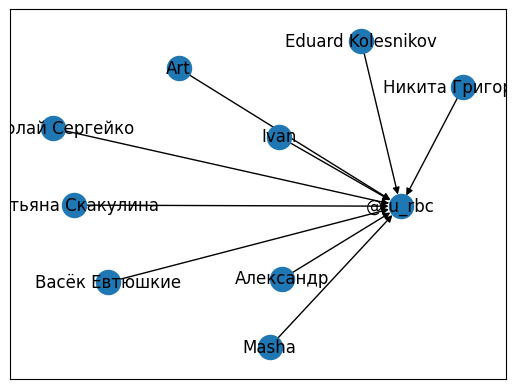

In [70]:
print("Visualizing a small subset of connections...")

subgraph = G.subgraph(list(G.nodes)[:10])

subgraph_pos = nx.spring_layout(subgraph)

nx.draw_networkx(subgraph, subgraph_pos)


<h2>Network Anslysis Questions:</h2>

1. How many connections are overlapping within each given group. (e.g. how
many people following SWJ also follow NYT)
2. How many overlaps are there in between clusters from different groups?

3. Do nodes cluster into tightly connected groups?

<h2>Network Visualization Questions</h2>

3. Visualize the connections in pretty way
4. Visualize Cluster sizes
5. Visualize groups by color coding them

<h2>Sentiment Analysis Questions</h2>
1. Word Cloud: what are people within each group discussing (Use entity recognition)?

2. Tag Cloud: who are people within each group discussing?

3. What sentiment do mentions within each groups have?

4. What is a general Twitter sentiment on this topic (Can use Ukraine dataset)

<h2>Visualization Techniques that can be leveraged</h2>
1. Network Visualization

2. Coloring nodes

3. Coloring Connections

4. Size of the nodes

5. Shape of the nodes


In [74]:
subgraph.nodes()

NodeView(('Александр', 'Никита Григорьев', 'Masha', '@ru_rbc', 'Ivan', 'Art', 'Eduard Kolesnikov', 'Васёк Евтюшкие', 'Николай Сергейко', 'Татьяна Скакулина'))

In [36]:
print("Running analysis on the network...")

# https://subscription.packtpub.com/book/big-data-and-business-intelligence/9781789955316/7

Running analysis on the network...


In [37]:
import networkx.algorithms.community as nxcom

# identifying communities within the network
twitter_communities = sorted(nxcom.greedy_modularity_communities(G), key=len,
                             reverse=True)

In [38]:
print("The number of communities detected is ", len(twitter_communities))

The number of communities detected is  2


In [39]:
print("Visualizing Identified Communities")

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

Visualizing Identified Communities


In [40]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [41]:
# Set node and edge communities
set_node_community(G, twitter_communities)
set_edge_community(G)

# Set community color for nodes
node_color = [
    get_color(G.nodes[v]['community'])
    for v in G.nodes]

# Set community color for internal edges
external = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] == 0]

internal = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] > 0]

internal_color = [
    get_color(G.edges[e]['community'])
    for e in internal]

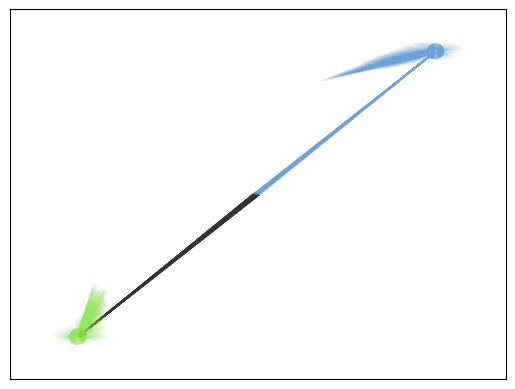

In [42]:
# Draw external edges
# NOTE: plotting large network with labels is causing a problem

nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=external, edge_color="#333333",
    alpha=0.2, with_labels=False)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=False)

Visualizing only clusters of nodes


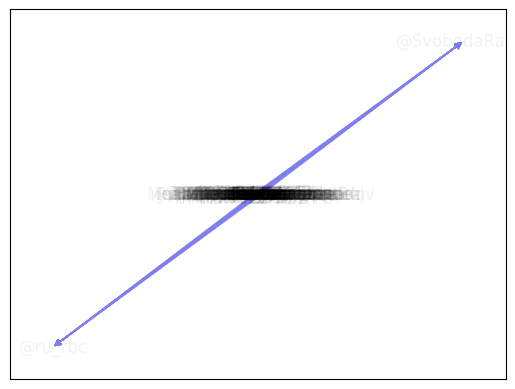

In [43]:
print("Visualizing only clusters of nodes")

G_core_30 = nx.k_core(G, 2)

nx.draw_networkx(
    G_core_30, pos=pos, node_size=2,
    edge_color="#7F7FEF", alpha=0.05, with_labels=True)

In [87]:
def get_node_attr_dict(graph_df):
    node_attr_dict = {}
    node_idx = 0
    cols = graph_df.columns
    for row in graph_df.iterrows():
        attrs = list((row[1]))
        inner_attr_dict = {
            cols[0] : attrs[0],
            cols[1] : attrs[1],
            cols[2] : attrs[2],
            cols[3] : attrs[3],
            cols[4] : attrs[4],
            cols[5] : attrs[5],
        }
        node_attr_dict[node_idx] = inner_attr_dict
        node_idx += 1
    return node_attr_dict

In [88]:
from networkx import convert_node_labels_to_integers

# WHAT ARE THE NODES INITIALIZED TO , attributes are added based on the node
# names?

print("Performing connectivity analysis on a graph")

# https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.nodes.html

# global_graph_pd = pd.DataFrame(columns=['username', 'user_id',
#                                      'cluster_name', 'cluster_id',
#                                      'cluster_follow_count', 'group_id'])

# find people who belong to multiple clusters within the same group

# could split global df into multiple dfs and perform matching on them

# or find connections between all graph nodes

# reference: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.connectivity.all_pairs_node_connectivity.html

# reindexing reference: https://networkx.org/documentation/stable/reference/generated/networkx.relabel.convert_node_labels_to_integers.html#networkx.relabel.convert_node_labels_to_integers


global_graph_attr_dict = get_node_attr_dict(global_graph_pd)

# PROBLEM: CLUSTERS DON'T NEED TO BE AUGMENTED

indexed_G = convert_node_labels_to_integers(G, label_attribute='Username')

# https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_node_attributes.html

nx.set_node_attributes(indexed_G, global_graph_attr_dict)

# attr = nx.get_node_attributes(G, name="group_id")

Performing connectivity analysis on a graph


In [90]:
G.nodes().data()

NodeDataView({'Ivan': {}, '@ru_rbc': {}, 'Masha': {}, 'Александр': {}, 'Васёк Евтюшкие': {}, 'Татьяна Скакулина': {}, 'Eduard Kolesnikov': {}, 'Никита Григорьев': {}, 'Николай Сергейко': {}, 'Art': {}, 'Alizamin': {}, 'Agamergen Isangulyyew': {}, 'Дмитрий Коротков': {}, 'Карлен': {}, 'resmon': {}, 'lazybuzzy': {}, 'кожаный ветер': {}, 'Begzod': {}, 'Светлана Конджария': {}, 'Иван Березовский': {}, 'Барлас Нурлан': {}, 'Чайка': {}, 'Аристарх Растопчин': {}, 'Denis Vilman': {}, 'Максим Иванов': {}, 'Khludan': {}, 'Евгений Смирнов': {}, 'Aziz Khaydarov': {}, 'Da Phantom Shtr': {}, 'Фамилия': {}, 'Janelle Stephens': {}, 'Arvydas': {}, 'В.К.С_тат': {}, 'ruppinwin Odessa': {}, 'Alina _Emoili': {}, 'ERIMBET': {}, 'Oxana': {}, 'Ismoil': {}, 'Эржигит Толонбек': {}, 'Nursultan Baisakalov': {}, 'yulya': {}, 'Jez': {}, 'Nadin': {}, 'TK': {}, 'Петр': {}, 'Vvhale': {}, 'Роман Колин': {}, 'Ciupaga': {}, 'Zebo Xaydarova': {}, 'antapo': {}, 'Sergey63': {}, 'Al': {}, 'Lev': {}, 'Коротенко Алексей': {}, 

In [89]:
indexed_G.nodes().data()

NodeDataView({0: {'Username': 'Ivan', 'username': 'Ivan', 'user_id': 1598081154346897429, 'cluster_name': '@ru_rbc', 'cluster_id': 269770723, 'cluster_follow_count': 535561, 'group_id': 0}, 1: {'Username': '@ru_rbc', 'username': 'Masha', 'user_id': 469707032, 'cluster_name': '@ru_rbc', 'cluster_id': 269770723, 'cluster_follow_count': 535561, 'group_id': 0}, 2: {'Username': 'Masha', 'username': 'Александр', 'user_id': 1598076287687577605, 'cluster_name': '@ru_rbc', 'cluster_id': 269770723, 'cluster_follow_count': 535561, 'group_id': 0}, 3: {'Username': 'Александр', 'username': 'Васёк Евтюшкие', 'user_id': 1598072695173906440, 'cluster_name': '@ru_rbc', 'cluster_id': 269770723, 'cluster_follow_count': 535561, 'group_id': 0}, 4: {'Username': 'Васёк Евтюшкие', 'username': 'Татьяна Скакулина', 'user_id': 1598071689425944583, 'cluster_name': '@ru_rbc', 'cluster_id': 269770723, 'cluster_follow_count': 535561, 'group_id': 0}, 5: {'Username': 'Татьяна Скакулина', 'username': 'Eduard Kolesnikov'

In [82]:
subgraph.nodes

NodeView(('Александр', 'Никита Григорьев', 'Masha', '@ru_rbc', 'Ivan', 'Art', 'Eduard Kolesnikov', 'Васёк Евтюшкие', 'Николай Сергейко', 'Татьяна Скакулина'))

In [72]:
Graph = nx.path_graph(3)
Graph.add_node('9')
attrs = {0: {"attr1": 20, "attr2": "nothing"}, '9': {"attr2": 3}}
nx.set_node_attributes(Graph, attrs)
print(Graph.nodes)

[0, 1, 2, '9']


In [51]:
global_graph_attr_dict

{'0': {'username': 'Ivan',
  'user_id': 1598081154346897429,
  'cluster_name': '@ru_rbc',
  'cluster_id': 269770723,
  'cluster_follow_count': 535556,
  'group_id': 0},
 '1': {'username': 'Masha',
  'user_id': 469707032,
  'cluster_name': '@ru_rbc',
  'cluster_id': 269770723,
  'cluster_follow_count': 535556,
  'group_id': 0},
 '2': {'username': 'Александр',
  'user_id': 1598076287687577605,
  'cluster_name': '@ru_rbc',
  'cluster_id': 269770723,
  'cluster_follow_count': 535556,
  'group_id': 0},
 '3': {'username': 'Васёк Евтюшкие',
  'user_id': 1598072695173906440,
  'cluster_name': '@ru_rbc',
  'cluster_id': 269770723,
  'cluster_follow_count': 535556,
  'group_id': 0},
 '4': {'username': 'Татьяна Скакулина',
  'user_id': 1598071689425944583,
  'cluster_name': '@ru_rbc',
  'cluster_id': 269770723,
  'cluster_follow_count': 535556,
  'group_id': 0},
 '5': {'username': 'Eduard Kolesnikov',
  'user_id': 1586014161657597955,
  'cluster_name': '@ru_rbc',
  'cluster_id': 269770723,
  'clu

In [46]:
# PROBLEM: NODES ARE IDENTIFIED BY USERNAME, WE WANT THEM TO BE IDENTIFIED BY
# THE INDEX WITH USERNAME AND OTHER ATTRIBUTES AS METADATA

# https://networkx.org/documentation/stable/reference/generated/networkx.relabel.relabel_nodes.html


G_nodes = list(G.nodes)

# print(G_nodes[0])

print(G.nodes.data())

# global_graph_attr_dict

# global_graph_attr_dict

# WILL ADD USRNAMES AS LABELS
# nx.draw(G,with_labels=True)

[('Ivan', {'community': 2}), ('@ru_rbc', {'community': 2}), ('Masha', {'community': 2}), ('Александр', {'community': 1}), ('Васёк Евтюшкие', {'community': 2}), ('Татьяна Скакулина', {'community': 2}), ('Eduard Kolesnikov', {'community': 1}), ('Никита Григорьев', {'community': 2}), ('Николай Сергейко', {'community': 1}), ('Art', {'community': 2}), ('Alizamin', {'community': 1}), ('Agamergen Isangulyyew', {'community': 2}), ('Дмитрий Коротков', {'community': 2}), ('Карлен', {'community': 2}), ('resmon', {'community': 2}), ('lazybuzzy', {'community': 2}), ('кожаный ветер', {'community': 2}), ('Begzod', {'community': 2}), ('Светлана Конджария', {'community': 1}), ('Иван Березовский', {'community': 2}), ('Барлас Нурлан', {'community': 2}), ('Чайка', {'community': 2}), ('Аристарх Растопчин', {'community': 1}), ('Denis Vilman', {'community': 2}), ('Максим Иванов', {'community': 1}), ('Khludan', {'community': 2}), ('Евгений Смирнов', {'community': 2}), ('Aziz Khaydarov', {'community': 2}), ('D

/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127464 (\N{REGIONAL INDICATOR SYMBOL LETTER C}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127475 (\N{REGIONAL INDICATOR SYMBOL LETTER N}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128038 (\N{BIRD}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  func(*args, **kwargs)
/Users/dennisfenchenko/NYU-Fall-2022/info_

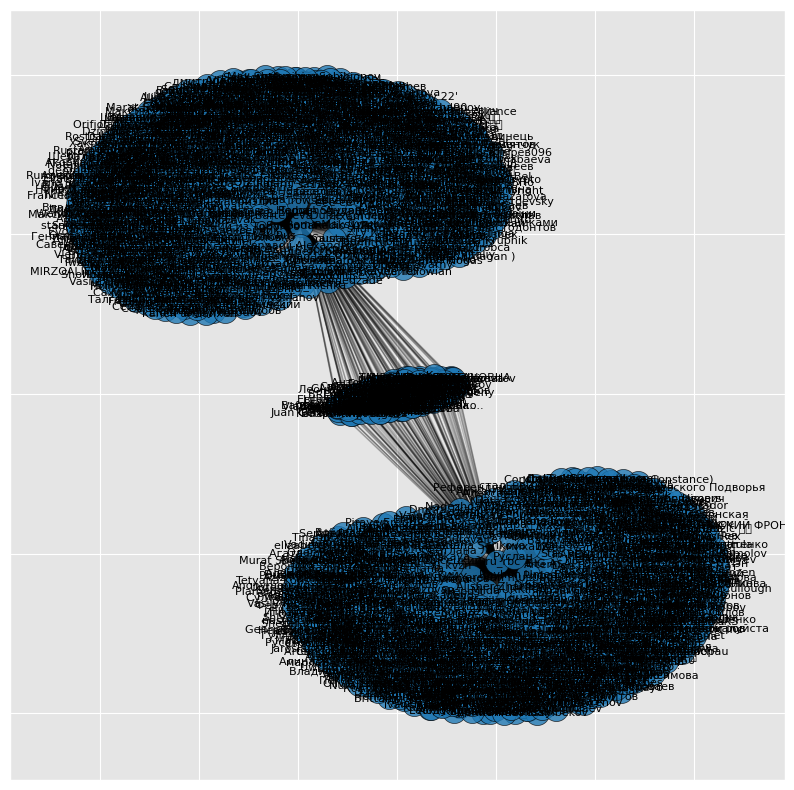

In [164]:
'''
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
'''

In [ ]:
# TODO: analyze social network graph using NetworkX
# TODO: perhaps the network should be cleaned of low degree connected users
#  for visualization purposes
# TODO: run the graph analytics on the original network w/o visualizing it

<h2>Visualizing the Network using Gephi</h2>

In [ ]:
# TODO: node size should correspond to the number of followers the node has
# TODO: node color should correspond to the node group